# Quickstart guide

## Introduction
Quicklst ist a python library for reading .lst files produced by FAST ComTec's mpa system. It uses numba to accelerate the reading of the file and supports block or chunk wise loading of large files.



## First Steps
Opening a list file is simple:

In [1]:
import quicklst
# to keep the git small we use a compressed lst file
import tarfile
with tarfile.open("demo.tar.xz", mode="r:xz") as tf:
    tf.extractall()
lf = quicklst.ListFile("demo.lst")

The primary purpose of Quicklst is to generate 2d histograms from list files, this is facilitated by the method `hist2d`.

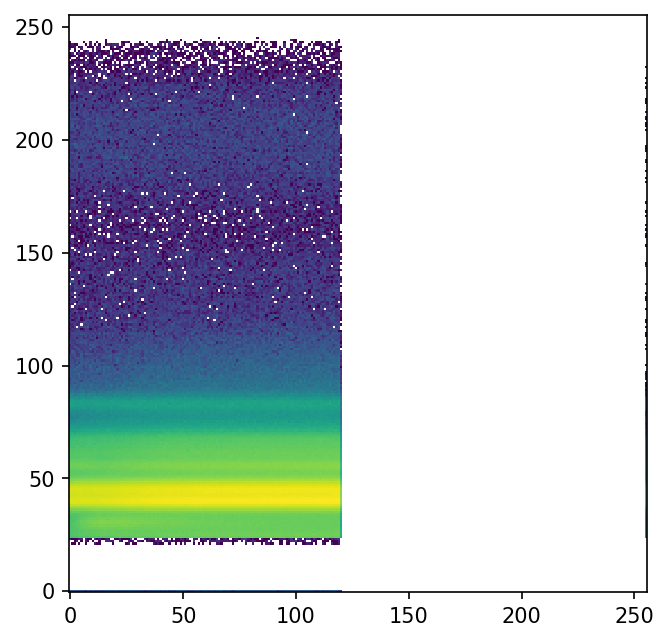

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
hist = lf.hist2d(0, 2, 32, 32)
plt.figure(figsize=(5, 5), dpi=150)
plt.imshow(hist, origin='lower', interpolation="none", norm=LogNorm())

Here the first two arguments to `hist2d` are the adcs of the x and y axis and the two following are binning values.
The used 32 means that 32 channels in the list file are summed up to generate one output channel in the histogram.

__Note__: quicklst counts the adcs from 0 so you have to subtract one from the adc number used by MPANT.

Functions are documented, and you can access the documentation via the `?` syntax in a python REPL or a jupyter notebook.

In [3]:
lf.hist2d?

To check which adcs where enabled during a measurement the ListFile class provides the method `get_active_adcs`

In [4]:
active_adcs = lf.get_active_adcs()
print(active_adcs)
for i, v in enumerate(active_adcs):
    print(f"ADC{i} is {'Active' if v else 'Inactive'}")

[ True  True  True  True  True  True False False]
ADC0 is Active
ADC1 is Active
ADC2 is Active
ADC3 is Active
ADC4 is Active
ADC5 is Active
ADC6 is Inactive
ADC7 is Inactive


## Buildin methods
Simmilarly to the 2d histogram you can also look at just one channel:

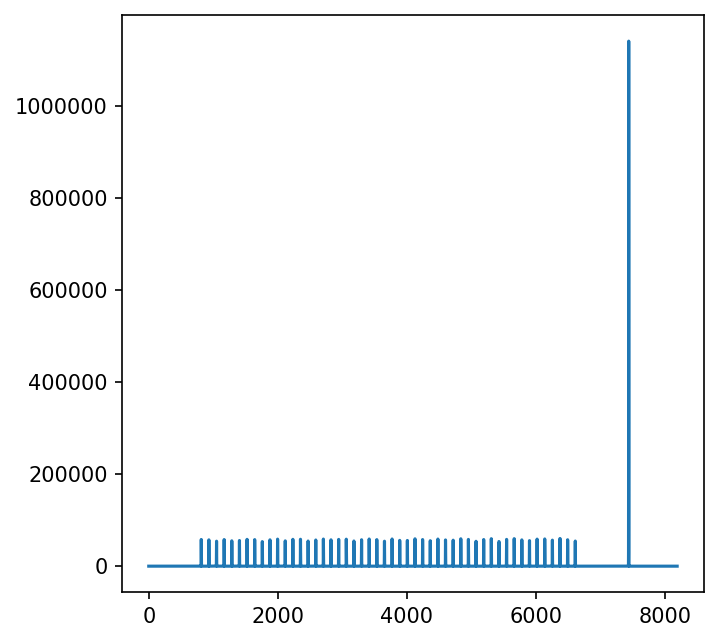

In [5]:
plt.figure(figsize=(5, 5), dpi=150)
plt.plot(lf.hist1d(3, 1))

Quicklst makes enforcing your own more complicated coincidence rules harder than other solutions which gives you access
to each event using a simple iterator. Therefore, some common restrictions are already implemented:

`hist2d_area_of_interest` is just like `hist2d` with the added restriction that it only counts events where a third adc
`adc_aoi` has values between `aoi_min` and `aoi_max`.

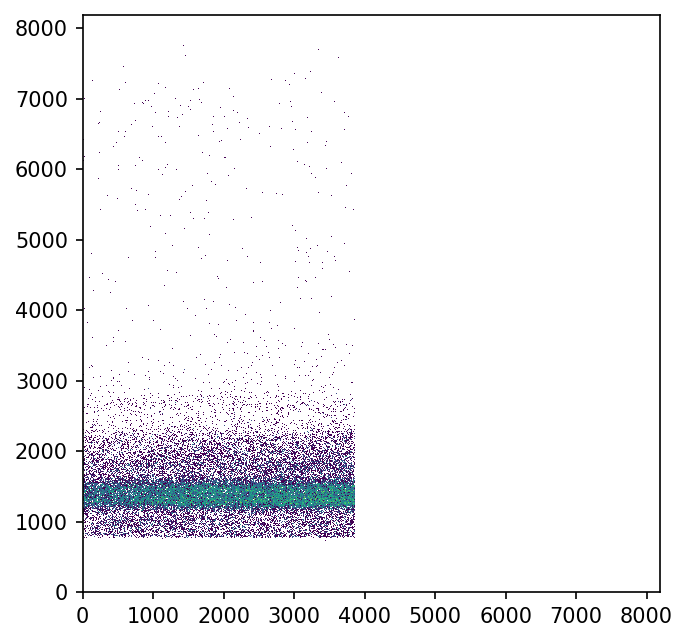

In [6]:
plt.figure(figsize=(5, 5), dpi=150)
hist = lf.hist2d_area_of_interest(0, 2, adc_aoi=3, aoi_min=100, aoi_max=7000)
plt.imshow(hist, origin='lower', norm=LogNorm(), interpolation="none")

in the same vain time can be restricted using `hist2d_time_of_interest`:

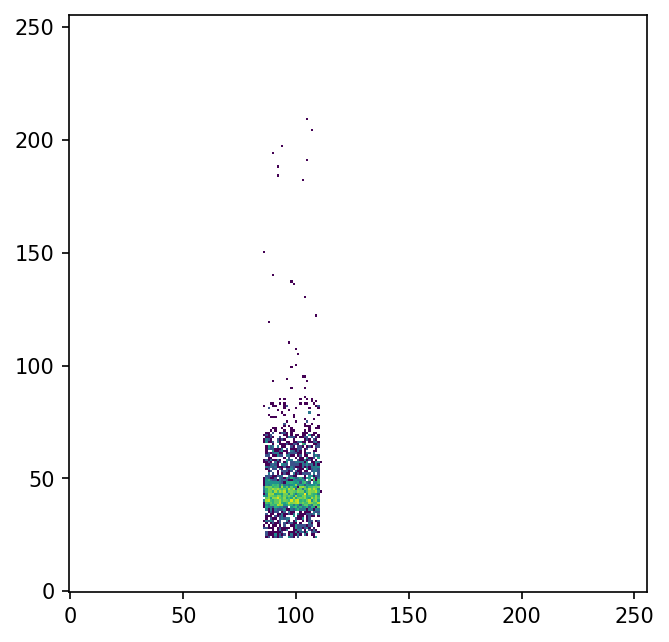

In [7]:
plt.figure(figsize=(5, 5), dpi=150)
hist = lf.hist2d_time_of_interest(0, 2, time_min=0, time_max=200, bin_size_x=32, bin_size_y=32)
plt.imshow(hist, origin='lower', norm=LogNorm(), interpolation="none")

Time is in this case the millisecond timestamps in the list file and not to the optional real time clock available on some mpa systems, the real time clock is not implemented in quicklst.

It is also possible to plot the values of one adc over time in a 2d histogram:

/home/goes/.conda/envs/deploy_env/lib/python3.9/site-packages/quicklst/quicklst.py:285: UserWarning: Last time bin is shorter than the others
  warnings.warn("Last time bin is shorter than the others")


Text(0, 0.5, 'Adc3')

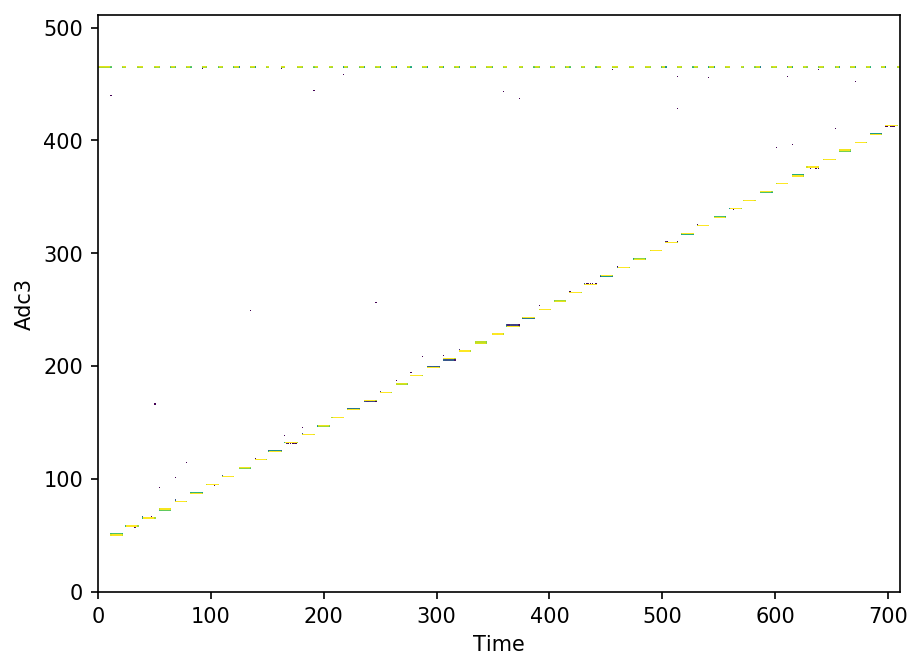

In [8]:
plt.figure(figsize=(7, 5), dpi=150)
hist = lf.hist2d_time_adc(3, 1000, 0, None, 16)
plt.imshow(hist.T, origin='lower', interpolation="none", norm=LogNorm())
plt.xlabel("Time")
plt.ylabel("Adc3")

## Advanced usage

If none of the build in methods cover your use case you will have to deal with events manually. You can access the list file through an iterator:

In [9]:
for block in lf.blocks():
    ...

each `block` is a chunk of the listfile data a block has the following structure:
* `time` is an array of `int64` counting the milliseconds since start of the measurement each entry representing one event in `adc`
* `adc` is a matrix of type `uint16` with the shape (number_of events, number of active adcs) this contains all the values for each event and adc
* `active_adcs` contains  a bit mask of active adcs where a set bit at index i corresponds to an active adc i
* `adc_map` is an array of `int32` where the number at index i is the index of adc i in hte `adc` array
* `read_up_to` is a private field and should be left as is

it is recommended to avoid loops in the iteration as they can be detrimental to performance, if you can not avoid them you might want to look into compiling your function using cython or numba's @njit.